In [1]:
# Import the "python" model called lake model (lakemodel_function.py)
from lakemodel_function import lake_problem

# Import some important ema_library function 
from ema_workbench import Model, RealParameter, ScalarOutcome, Constant
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging, MultiprocessingEvaluator

# import library to generate random values
import random

# Import PRIM library
import prim as prm

# Library to calculate the duration of experiments
import time

# standard python library for data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# define to show the log of ema_workbench
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## 1.2 Model Definition

In [2]:
#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

## 1.3 Policy Definition

In [3]:
policy_0 = Policy("No release", **{l.name:0 for l in lake_model.levers})
policy_quarter = Policy("Quarter release", **{l.name:random.randint(0, 25)/100 for l in lake_model.levers})
policy_half = Policy("Half release", **{l.name:random.randint(25, 50)/100 for l in lake_model.levers})
policy_max = Policy("Max release", **{l.name:random.randint(50, 100)/100 for l in lake_model.levers})

## 1.4 Perform Experiments

In [4]:
start = time.time()

n_scenarios = 1000
results = perform_experiments(lake_model, n_scenarios, [policy_0,policy_quarter,policy_half,policy_max])

end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished


Processing time : 8.00665378967921 Minutes


## 1.5 Separating Experiments 

In [5]:
experiments, outcomes= results

dfexperiment = pd.DataFrame(data=experiments)
dfoutput = pd.DataFrame(data=outcomes)

In [6]:
df_experiment = pd.read_csv('dfexperiment.csv')
df_output = pd.read_csv('dfoutput.csv')

## 1.6 Policy Definition

In [7]:
select_policy_0 = (df_experiment.policy == 'No release')
select_policy_quarter = (df_experiment.policy == 'Quarter release')
select_policy_half = (df_experiment.policy == 'Half release')
select_policy_max = (df_experiment.policy == 'Max release')

In [8]:
# Select policy to do Prim
a_x_prim_0 = df_experiment[select_policy_0].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
a_y_prim_0 = (df_output[select_policy_0]['max_P'] > 
              df_output[select_policy_0]['max_P'].quantile(.95)).astype(int).reset_index(drop=True)

In [9]:
a_y_prim_0

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      1
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
2970    0
2971    0
2972    0
2973    0
2974    0
2975    0
2976    0
2977    0
2978    0
2979    0
2980    0
2981    0
2982    0
2983    0
2984    0
2985    0
2986    0
2987    0
2988    0
2989    0
2990    0
2991    0
2992    0
2993    0
2994    0
2995    0
2996    1
2997    0
2998    0
2999    0
Name: max_P, Length: 3000, dtype: int32

## 1.7 PRIM 

In [10]:
prim_alg_0 = prm.Prim(a_x_prim_0, a_y_prim_0, threshold=0.8 ,threshold_type=">")
box1_0 = prim_alg_0.find_box()

### 1.7.1 Tradeoff within dimension

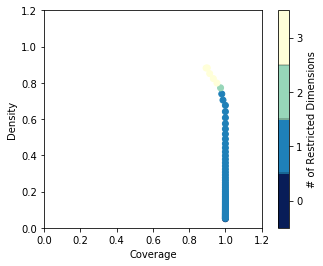

In [11]:
%matplotlib inline
#%matplotlib notebook
box1_0.show_tradeoff()
plt.show()

### 1.7.2 Choose box 54

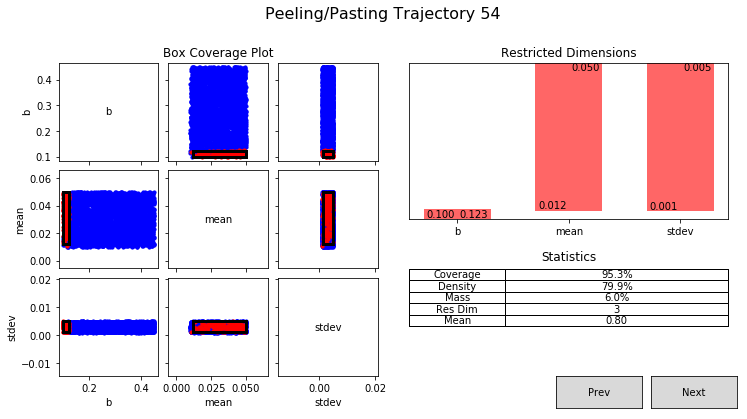

In [12]:
box_selection = 54
box1_0.select(box_selection)
box1_0.show_details()
plt.show()